Assignment Four - CRISP-DM Capstone: Association Rule Mining, Clustering, or Collaborative Filtering
===
##Hector Curi - Spencer Kaiser

---
Instructions
---
In the final assignment for this course, you will be using one of three different analysis methods:

* Option A: Use transaction data for mining associations rules
* Option B: Use clustering on an unlabeled dataset to provide insight or features
* Option C: Use collaborative filtering to build a custom recommendation system

Your choice of dataset will largely determine the task that you are trying to achieve. Though the dataset does not need to change from your previous tasks. For example, you might choose to use clustering on your data as a preprocessing step that extracts different features. Then you can use those features to build a classifier and analyze its performance in terms of accuracy (precision, recall) and speed. Alternatively, you might choose a completely different dataset and perform rule mining or build a recommendation system.

---
Dataset Selection and Toolkits
---
As before, you need to choose a dataset that is not small. It might be massive in terms of the number of attributes (or transactions), classes (or items, users, etc.) or whatever is appropriate for the task you are performing. Note that scikit-learn can be used for clustering analysis, but not for Association Rule Mining (you should use R) or collaborative filtering (you should use graphlab-create from Dato). Both can be run using iPython notebooks as perfomed in class.

Write a report covering in detail all the steps of the project. The results need to be reproducible using only this report. Describe all assumptions you make and include all code you use in the iPython notebook or as supplemental functions. Follow the CRISP-DM framework in your analysis (you are performing all of the CRISP-DM outline). This report is worth 20% of the final grade.

---
### Choice of Task
We are going to use the MovieLens movie ratings dataset to complete **Option C**. We plan on utilizing over 100,000 user ratings of 8,570 movies to create a item-item recommender and a recommendation system using collaborative filtering.

---
### Initial Code
Our first task was to create a usable dataset from the individual files created by MovieLens. We accomplished this by using the pandas `merge` function, then we wrote the result to a new file called `data.csv`. Each instance in this file now contains the id of both the user and the movie, the movie title, its rating, genres, and more.

In [3]:
#import all packages used in this assignment
import graphlab as gl
import graphlab.aggregate as agg
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from numpy import random as rd
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# read in the separate csv files (ratings and movies) and combine them into one for easier use
df1 = pd.read_csv('data/ratings.csv')
df2 = pd.read_csv('data/movies.csv')
merged = df1.merge(df2, on="movieId", how="outer").fillna("")
merged.to_csv("data/data.csv", index=False)

# read in final merged file as both an sframe and a dataframe
data = gl.SFrame.read_csv("data/data.csv")
# embed graphs to ipython
gl.canvas.set_target('ipynb')

PROGRESS: Finished parsing file /Users/Spencer/Dev/DataMining/04_AssignmentFour/data/data.csv
PROGRESS: Parsing completed. Parsed 100 lines in 0.186105 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[float,float,float,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /Users/Spencer/Dev/DataMining/04_AssignmentFour/data/data.csv
PROGRESS: Parsing completed. Parsed 100041 lines in 0.198909 secs.


Business Understanding
---

---
### 1. Business Purpose & Implications of Analysis (10 points)
**Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm and why does this method make sense for this specific dataset and the stakeholders needs?**

We chose the MovieLens Data Set from Department of Computer Science and Engineering at the University of Minnesota, Twin Cities at http://grouplens.org/datasets/movielens/.

The primary purpose of this dataset, and it’s creation, is for research purposes. Other similar datasets have been made, however, these datasets were primarily made available for competition purposes in order to improve a business’s recommendation model.

Regarding how an analysis of this data set may be used in the real-world, one of the most beneficial uses of the resulting system would be for movie streaming services like Netflix. Netflix is constantly adding new movies to their offering that they believe will be in high demand. At the same time, they are constantly removing under-performing titles. They do this in order to maximize the revenue generated from each title after paying licensing fees, to make sure their offering remains current and relevant, and they also do this to ensure that users of the service are happy with what they are paying for. 

Our recommendation system could be used to help Netflix fine-tune their offering to best meet the needs of their current subscribers. It could be used to help identify new movies that may be popular and it could also be used to help determine which movies are the least popular.

We will use cross validation to measure the effectiveness of our algorithm. Using precision and recall, we can estimate how many of our recommender system predictions are correct and how many don't match our testing set.

Data Understanding
---

---
### 1. Data Meaning (10 points)
**Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?**

Attribute | Type | Range / Values | Description 
--- | --- | --- | ---
userId | Nominal | 1 - 706 | Randomly assigned user ID's
movieId | Nominal | 1 - 129651 | Randomly assigned movie ID's
rating | Ordinal | 0.5 - 5.0 | Individual rating given to each movie by a user 
timestamp | Interval | 828504918 - 1427754939 | Represent how many seconds after midnight Coordinated Universal Time (UTC) of January 1, 1970 the rating was made
title | Nominal | N/A | Title of the movie 
genres | Nominal | Action, Adventure, Animation, Children’s, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western, N/A '(no genres listed)' | Genre or genres assigned to each movie 


Data collection for this dataset began in April of 1996. Since then, the data set has gone through multiple iterations and the result is a high-quality, well-polished dataset. The dataset does not contain missing values in the traditional sense, however, according to the creators of the dataset “Only movies with at least one rating or tag are included in the dataset”, so some instances have missing values for the ratings field. Because the the quantity of these types of instances is low and because we are primarily focusing on rating, we will be removing these instances from the data set.

In [4]:
#here we drop all the rows that have missing values, which are basically the bottom 18 rows that are movies without ratings
data = data.dropna()

In [5]:
# Use the head to get a general idea of how the data in our data set looks like
data.head()

Columns:
	userId	float
	movieId	float
	rating	float
	timestamp	float
	title	str
	genres	str

Rows: 10

Data:
+--------+---------+--------+--------------+-------------+-----------------------+
| userId | movieId | rating |  timestamp   |    title    |         genres        |
+--------+---------+--------+--------------+-------------+-----------------------+
|  1.0   |   6.0   |  2.0   | 980730861.0  | Heat (1995) | Action|Crime|Thriller |
|  8.0   |   6.0   |  5.0   | 964736358.0  | Heat (1995) | Action|Crime|Thriller |
|  9.0   |   6.0   |  3.0   | 844674216.0  | Heat (1995) | Action|Crime|Thriller |
|  16.0  |   6.0   |  2.0   | 855198917.0  | Heat (1995) | Action|Crime|Thriller |
|  19.0  |   6.0   |  4.0   | 1154985045.0 | Heat (1995) | Action|Crime|Thriller |
|  21.0  |   6.0   |  4.0   | 865106909.0  | Heat (1995) | Action|Crime|Thriller |
|  31.0  |   6.0   |  5.0   | 1186249974.0 | Heat (1995) | Action|Crime|Thriller |
|  60.0  |   6.0   |  5.0   | 1264525122.0 | Heat (1995) | Action|Crime|Thriller |
|  87.0  |   6.0   |  5.0   | 848503814.0  | Heat (1995) | Action|Crime|Thriller |
|  96.0  |   6.0   |  5.0   | 882593416.0  | Heat (1995) | Action|Crime|Thriller |
+--------+---------+--------+--------------+-------------+-----------------------+
[10 rows x 6 columns]

Furthermore, there are no apparent outliers in the set. The scale users rank movies on allows values from 0.5 to 5.0 with increments of 0.5. After running a `min` and a `max` of the dataset, we can see there are no incorrect values (outliers in this case) for the ratings field. Lastly, the dataset contains no duplicate instances.

---
### 2. Visualization of Attributes (10 points)
**Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.**

Here is a general breakdown of our data provided by the Graphlab library.

In [6]:
data.show()

<IPython.core.display.Javascript object>

This next graph shows the distribution of ratings in our data set.

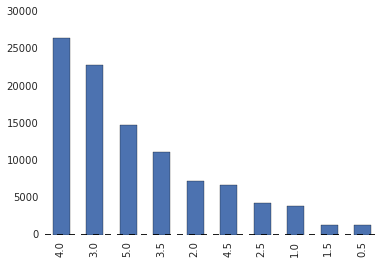

In [7]:
df = data.to_dataframe()
df['rating'].value_counts().plot(kind='bar')

As we can see most ratings were 4's and 3's, followed by 5's. The least amount of ratings were 0.5's and 1.5s'.

This was very unexpected for us. We had an initial hypthesis that the ratings were going to be mostly 5's and 1's, based on our belief that most people either hate or love the movies they rate. But apparently not.

We think that this distribution now makes sense after reflecting a bit and realizing that people tend to watch movies that are of somewhat interest to them and thus very hard to completely hate. This then causes them to evaluate them from a perfect movie at a 5 rating and downward, causing these many 4's and 3's. Ratings of 1's and lower probably were not given that much because the user probably wouldn't even watch movies that are so different from their tastes, thus explaining their low frequency.

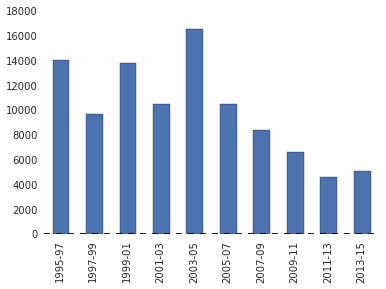

In [8]:
df['time_range'] = pd.cut(df.timestamp,[828504917,891576917,954648917,1017720917,1080792917,1143864917,1206936917,1270008917,1333080917,1396152917,1427754940],10,labels=['1995-97','1997-99','1999-01','2001-03','2003-05','2005-07','2007-09','2009-11','2011-13','2013-15'])
df['time_range'].value_counts(sort = False).plot(kind='bar')

The graph above shows when the ratings were made according to their timestamps.

We can see that the most ratings were done on the period from 2003 to 2005, and have declined since. There is a slight increase in the last period of 2013-15.

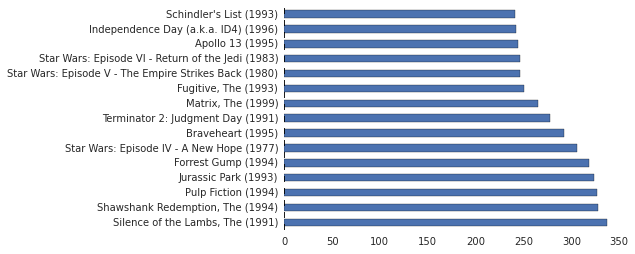

In [9]:
titles = df['title'].value_counts()
titles.head(15).plot(kind='barh')

The graph above shows the top rated movies in our data set. Next we will show some descriptive statistics of this distribution and a more detailed explanation.

In [10]:
titles.describe()

count    8551.000000
mean       11.697228
std        26.012950
min         1.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       337.000000
dtype: float64

So the minimum is obviously 1, because our data set has to contain at least one rating per movie. The maximum however is 337, corresponding to Silence of the Lambs. Many of the top rated movies are also big blockbuster films, which tends to bias a recommender to always show popular movies as opposed to being indifferent to this factor. It is also interesting to note how many movies have only one rating. All of the lowest 25th percentile is in this range.

However let's now see what percentage of the total ratings does Silence of the Lambs take in the following chart.

In [11]:
numRatings = data['title']
numRatings.show()

<IPython.core.display.Javascript object>

The previous chart shows that even the most rated movie only has 0.33 % of the total ratings making this dataset very unbiased.

---

In [12]:
data['userId'] = data['userId'].astype(str)
numRatingsPerPerson = data['userId']
numRatingsPerPerson.show()

<IPython.core.display.Javascript object>

In [13]:
userRatings = df['userId'].value_counts()
userRatings.describe()

count     706.000000
mean      141.675637
std       207.544088
min        20.000000
25%        34.000000
50%        67.000000
75%       157.500000
max      2268.000000
dtype: float64

The chart and data above break down the number of ratings submitted by individual users. The average user submitted about 140 ratings in a timespan of *up to* 19 years. This average seems entirely reasonable, however, the max number of ratings for any individual user is over 2,000! At first, this number seemed like it might have been an error in the data or there was an error in our code, but if you think about the number of movie fanatics there are in the US and if you break that down to the number of ratings per year (around 120 movies ratings per year, or one every few days), it becomes much more believable.

Overall, this data is very interesting. In addition, as a a result of requiring users to have at least 20 ratings in order to be included in this data set, the likelyhood of the data being consistent and accurate is very high.

---

Modeling and Evaluation (50 points)
---

Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

* Create user-item matrices or item-item matrices using collaborative filtering
* Determine performance of the recommendations using different performance measures.
* Use tables/visualization to discuss the found results.
* Describe your results. What findings are the most compelling and why?


---
### Item Similarity Recommender

Let's start by splitting our data into training and testing sets

In [14]:
train, test = gl.recommender.util.random_split_by_user(data,
                                                    user_id="userId", item_id="title",
                                                    max_num_users=100, item_test_proportion=0.2)

Now we will build an item similarity recommender using graphlab. We will tell it which parameters to use and then evaluate it.

In [15]:
item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test)

PROGRESS: Recsys training: model = item_similarity
PROGRESS: Warning: Ignoring columns movieId, timestamp, genres;
PROGRESS:     To use these columns in scoring predictions, use a model that allows the use of additional features.
PROGRESS: Preparing data set.
PROGRESS:     Data has 96807 observations with 706 users and 8491 items.
PROGRESS:     Data prepared in: 0.194285s
PROGRESS: Computing item similarity statistics:
PROGRESS: Computing most similar items for 8491 items:
PROGRESS: +-----------------+-----------------+
PROGRESS: | Number of items | Elapsed Time    |
PROGRESS: +-----------------+-----------------+
PROGRESS: | 1000            | 0.590002        |
PROGRESS: | 2000            | 0.616512        |
PROGRESS: | 3000            | 0.645824        |
PROGRESS: | 4000            | 0.674407        |
PROGRESS: | 5000            | 0.712467        |
PROGRESS: | 6000            | 0.744541        |
PROGRESS: | 7000            | 0.773434        |
PROGRESS: | 8000            | 0.822863    

This is very imprecise but we can see some of the results in the next cell.

In [16]:
results = item_item.get_similar_items(k=3)
results.head()

PROGRESS: Getting similar items completed in 0.032421


Columns:
	title	str
	similar	str
	score	float
	rank	int

Rows: 10

Data:
+-------------------------------+-------------------------------+----------------+
|             title             |            similar            |     score      |
+-------------------------------+-------------------------------+----------------+
|          Heat (1995)          |        Rock, The (1996)       | 0.521755712152 |
|          Heat (1995)          |      Broken Arrow (1996)      | 0.478869049191 |
|          Heat (1995)          | Independence Day (a.k.a. I... | 0.47085908045  |
|         Copycat (1995)        |       Son in Law (1993)       | 0.406135570136 |
|         Copycat (1995)        |       Just Cause (1995)       | 0.40406609243  |
|         Copycat (1995)        |       Get Shorty (1995)       | 0.400349335237 |
| Twelve Monkeys (a.k.a. 12 ... |   Usual Suspects, The (1995)  | 0.567815839935 |
| Twelve Monkeys (a.k.a. 12 ... | Terminator 2: Judgment Day... | 0.55686496185  |
| Twelve Monkeys (a.k.a. 12 ... |      Pulp Fiction (1994)      | 0.552594914889 |
|   Usual Suspects, The (1995)  |      Pulp Fiction (1994)      | 0.62888249077  |
+-------------------------------+-------------------------------+----------------+
+------+
| rank |
+------+
|  1   |
|  2   |
|  3   |
|  1   |
|  2   |
|  3   |
|  1   |
|  2   |
|  3   |
|  1   |
+------+
[10 rows x 4 columns]

In the table above, we can see a list of films (in the left column) and a list of similar films (in the middle column). After being given user ratings, we can use this information to determine which films should be recommended to a given user.

In [17]:
print rmse_results.viewkeys()
rmse_results['rmse_by_item'].show()

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])


<IPython.core.display.Javascript object>

In [18]:
rmse_results['rmse_by_user'].show()

<IPython.core.display.Javascript object>

The data above can be used as a good baseline indicator of the performance of our system. The data above is a measure of error (root mean squared error) for recommendations.

Additionally, we will print below the precision and recall by user, in order to see how it performs.

In [19]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

Columns:
	cutoff	int
	Avg of precision	float
	Stdv of precision	float
	Avg of recall	float
	Stdv of recall	float

Rows: 3

Data:
+--------+------------------+-------------------+------------------+
| cutoff | Avg of precision | Stdv of precision |  Avg of recall   |
+--------+------------------+-------------------+------------------+
|   10   |      0.018       |  0.0384187454246  | 0.0159088923114  |
|   15   | 0.0153333333333  |  0.0295972971739  | 0.0172125314177  |
|   5    |       0.02       |        0.06       | 0.00679798818816 |
+--------+------------------+-------------------+------------------+
+-----------------+
|  Stdv of recall |
+-----------------+
| 0.0492592601145 |
| 0.0498695630883 |
|  0.030372694519 |
+-----------------+
[3 rows x 5 columns]

---
### Recommender using Collaborative Filtering

Let's start by testing some parameters using parameter search. This process will run all of the different models and compile the results into a single table where we an see which one performed better.

In [20]:
job = gl.model_parameter_search(gl.recommender.ranking_factorization_recommender.create,
                             training_set=train, 
                             validation_set=test,
                             user_id="userId", 
                             item_id="title", 
                             target="rating",
                             num_factors=[8, 16, 32],
                             regularization=[0.001, 0.01, 0.1],
                             linear_regularization = [0.001, 0.01, 0.1])

[INFO] Validating job.
[INFO] Creating a LocalAsync environment called 'async'.
[INFO] Validation complete. Job: 'Model-Parameter-Search-May-12-2015-19-52-12' ready for execution
[INFO] Job: 'Model-Parameter-Search-May-12-2015-19-52-12' scheduled.


In [ ]:
# this line of code keeps us updated on the status of the job running in the background
job.get_status()

In [22]:
#once the job is done, we can store the results in job_results
job_result = job.get_results()

Now let's see what the job came up with. Let's print out the summary.

In [23]:
models = job_result['models']
summary_sframe = job_result['summary']
summary_sframe

Columns:
	model_id	int
	linear_regularization	float
	num_factors	int
	regularization	float
	training_precision@5	float
	training_recall@5	float
	training_rmse	float
	validation_precision@5	float
	validation_recall@5	float
	validation_rmse	float

Rows: 27

Data:
+----------+-----------------------+-------------+----------------+
| model_id | linear_regularization | num_factors | regularization |
+----------+-----------------------+-------------+----------------+
|    0     |          0.01         |      16     |      0.01      |
|    1     |         0.001         |      16     |      0.01      |
|    2     |         0.001         |      32     |      0.01      |
|    3     |         0.001         |      32     |      0.1       |
|    4     |          0.1          |      32     |     0.001      |
|    5     |          0.01         |      32     |      0.1       |
|    6     |          0.1          |      16     |      0.1       |
|    7     |         0.001         |      16     |      0.1       |
|    8     |          0.1          |      16     |     0.001      |
|    9     |          0.01         |      16     |      0.1       |
+----------+-----------------------+-------------+----------------+
+----------------------+-------------------+----------------+------------------------+
| training_precision@5 | training_recall@5 | training_rmse  | validation_precision@5 |
+----------------------+-------------------+----------------+------------------------+
|    0.406515580737    |  0.0258056328101  | 1.02459120382  |         0.172          |
|    0.406515580737    |  0.0258056328101  | 0.981655721522 |         0.174          |
|    0.405949008499    |  0.0250574062386  | 0.981670669712 |          0.17          |
|    0.406515580737    |  0.0258056328101  | 1.01445035906  |         0.162          |
|    0.382436260623    |  0.0247037682573  | 1.02507757217  |          0.15          |
|    0.406515580737    |  0.0258056328101  | 1.02767644688  |         0.172          |
|    0.406515580737    |  0.0258056328101  | 1.05803848088  |         0.166          |
|    0.406515580737    |  0.0258056328101  | 1.01435289014  |         0.162          |
|    0.388668555241    |  0.0254151646039  | 1.02861865215  |          0.15          |
|    0.406515580737    |  0.0258056328101  | 1.02766196961  |          0.17          |
+----------------------+-------------------+----------------+------------------------+
+---------------------+-----------------+
| validation_recall@5 | validation_rmse |
+---------------------+-----------------+
|   0.0370681920236   |  1.06108776727  |
|   0.0363739293762   |  1.03833732208  |
|   0.0328025008047   |  1.03805871729  |
|   0.0350313797506   |  1.06165385674  |
|    0.034064282702   |  1.06046319876  |
|   0.0370681920236   |  1.06381629533  |
|   0.0364318477364   |  1.09109650112  |
|   0.0350313797506   |  1.06123573077  |
|   0.0369386043304   |  1.06369303103  |
|    0.036636542247   |  1.06373419971  |
|         ...         |       ...       |
+---------------------+-----------------+
[27 rows x 10 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

As you can see on the table above the parameters that gave us the best results were:

* num_factors = 16
* regularization = 0.01
* linear_regularization = 0.01

Now let's will use those and build our final recommender and test its results.

In [24]:
finalRec = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  num_factors=16, 
                                  regularization=0.01,
                                  linear_regularization = 0.01)

finalRec.save("final_model")
rmse_results = finalRec.evaluate(test)

PROGRESS: Recsys training: model = ranking_factorization_recommender
PROGRESS: Preparing data set.
PROGRESS:     Data has 96807 observations with 706 users and 8491 items.
PROGRESS:     Data prepared in: 0.248702s
PROGRESS: Training ranking_factorization_recommender for recommendations.
PROGRESS: +--------------------------------+--------------------------------------------------+----------+
PROGRESS: | Parameter                      | Description                                      | Value    |
PROGRESS: +--------------------------------+--------------------------------------------------+----------+
PROGRESS: | num_factors                    | Factor Dimension                                 | 16       |
PROGRESS: | regularization                 | L2 Regularization on Factors                     | 0.01     |
PROGRESS: | solver                         | Solver used for training                         | adagrad  |
PROGRESS: | linear_regularization          | L2 Regularization on Line

Below are some of the recommendations that our recommender provides.

In [25]:
results = finalRec.recommend(users=None, k=5)
results.head() # the recommendation output

Columns:
	userId	str
	title	str
	score	float
	rank	int

Rows: 10

Data:
+--------+-------------------------------+---------------+------+
| userId |             title             |     score     | rank |
+--------+-------------------------------+---------------+------+
|  614   |     American Beauty (1999)    | 3.59013703438 |  1   |
|  614   | Twelve Monkeys (a.k.a. 12 ... | 3.51774886968 |  2   |
|  614   |      Citizen Kane (1941)      | 3.51215758147 |  3   |
|  614   |         Amadeus (1984)        | 3.49394633594 |  4   |
|  614   |  Sense and Sensibility (1995) | 3.49119188609 |  5   |
|  616   |       Casablanca (1942)       | 3.56378981444 |  1   |
|  616   |   Princess Bride, The (1987)  | 3.53718613061 |  2   |
|  616   |      Citizen Kane (1941)      |  3.5205312294 |  3   |
|  616   |    Wizard of Oz, The (1939)   | 3.50789360675 |  4   |
|  616   |  Sense and Sensibility (1995) | 3.49956553402 |  5   |
+--------+-------------------------------+---------------+------+
[10 rows x 4 columns]

The table above is the final set of recommendations. The table contains each user in the data set and recommends 5 movies based on movies they’ve rated which the system believes are similar. Each users’ recommendations are ranked 1 to 5 by the strength of of their score, which is an estimation of what the user *should* rate the movie if they follow the recommendation.

In [26]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

Columns:
	cutoff	int
	Avg of precision	float
	Stdv of precision	float
	Avg of recall	float
	Stdv of recall	float

Rows: 3

Data:
+--------+------------------+-------------------+-----------------+
| cutoff | Avg of precision | Stdv of precision |  Avg of recall  |
+--------+------------------+-------------------+-----------------+
|   10   |      0.136       |   0.185752523536  | 0.0548583426105 |
|   15   |      0.122       |   0.154647987378  | 0.0763512429463 |
|   5    |      0.172       |   0.251427922077  | 0.0370681920236 |
+--------+------------------+-------------------+-----------------+
+-----------------+
|  Stdv of recall |
+-----------------+
| 0.0803062205665 |
| 0.0913365858371 |
| 0.0708336718594 |
+-----------------+
[3 rows x 5 columns]

Finally, the table above includes a few measurements of the overall accuracy of our model given the set of parameters discussed above. Overall, the system performs with a reasonable level of precision and recall.

Deployment (10 points)
---
Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you acheive your goals? If not, can you reign in the utility of your modeling?

---
### 1. Business Practicality
**How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?**

Our model could be very useful to certain businesses. In the example mentioned at the beginning of this notebook, we discussed how this system could be utilized by Netflix. Netflix could essentially use existing user ratings and existing movie selections to determine which movies are the least recommended for the majority of users (especially heavy users) and remove them from the service to avoid paying unnecessary fees. At the same time, they could use this system to help predict, given a set of available titles that could be added to the service, which movies would be the best performers for the existing user base, which may also be a good method of attracting new customers.

Given that this system generates recommendations, which is rather subjective, this would most likely be one of many steps involved in determining the best movies to add to the service, and the least desirable movies which can be removed. Overall, these actions may help boost the profitability of the service.

---
### 2. Deployment
**How would your deploy your model for interested parties?**

The current system is not ready for deployment, however, it could be easily modified and made ready for use in the real-world. A logical first step in preparing the system for deployment would involve creating a set of user profiles which would essentially be a way to bucket existing users into categories, and then incorporating this into the system itself. Every time Netflix would like to evaluate the current or determine which movies to add in the future, it would not make sense to generate recommendations for every single user. In addition, using this strategy, Netflix could conduct market research and generate user profiles for prospective customers and then recommendations could be made as to which movies could be added to the service to better attract *those* consumers.

In order to further prepare the system for deployment, the system would have to incorporate functionality to accept a set of films (the films that could potentially be added to the service) and then those films would have to be tested against each of the profiles mentioned above. The system would also have to be capable of changing the process to figure out the least recommended movies so they may be removed from the service.

This tool would be incorporated within Netflix and would continue to update itself as users rate films. Periodically, either automatically or manually, a set of prospective movies could be imported and the system could be run to determine which movies to add and which existing movies to remove.

---
### 3. Additional Data
**What other data should be collected?**

Once the system is deployed, Netflix could track how many users sign up for the service and how many cancel in between periods of adding/removing films based on the systems recommendations. In between these periods, the data by itself would be meaningless, however, after a year’s worth of data\* is obtained, trends may start to emerge. Furthermore, the data about which types of films were added/removed, along with the signup/cancellation data, could be mined for additional insight into the performance of the recommendation system.

\* It is very important that a year’s worth of data is obtained due to seasonal user fluctuations (e.g., increases in signups following Christmas and Valentines Day and cancellations 1-3 months after, depending on the most common types of service gifts).

---
### 4. System Maintenance
**How often would the model need to be updated, etc.?**

The model would most likely be updated prior to evaluating the current and potential film offerings. Prior to updating the model, Netflix would store all ratings data, signup data, and cancellation data. Whenever Netflix would like to add/remove films, they could rebuild the model with this new data and then make recommendations based on the updated model. Depending on the quantity of data, it may also make sense to remove older data to keep the model current.

Exceptional Work (10 points)
---

---
**You have free reign to provide additional analyses or combine analyses**

For the exceptional work component of this project, we did both an item-item recommender as well as a regular one using collaborative filtering. We also focused on making our written descriptions of the data set, the recommendation system, and description of the implications of that system as detailed as possible. We also made the effort to point out interesting findings in the data whenever we identified something that either met or did not meet our expectations.

Thank you for a great semester, enjoy your summer!

In [ ]:
                                 .''.
       .''.             *''*    :_\/_:     .
      :_\/_:   .    .:.*_\/_*   : /\ :  .'.:.'.
  .''.: /\ : _\(/_  ':'* /\ *  : '..'.  -=:o:=-
 :_\/_:'.:::. /)\*''*  .|.* '.\'/.'_\(/_'.':'.'
 : /\ : :::::  '*_\/_* | |  -= o =- /)\    '  *
  '..'  ':::'   * /\ * |'|  .'/.\'.  '._____
      *        __*..* |  |     :      |.   |' .---"|
       _*   .-'   '-. |  |     .--'|  ||   | _|    |
    .-'|  _.|  |    ||   '-__  |   |  |    ||      |
    |' | |.    |    ||       | |   |  |    ||      |
 ___|  '-'     '    ""       '-'   '-.'    '`      |____